#### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")

#### Load data

In [2]:
df_attribution = pd.read_csv("attribution data.csv")

#### Sorting the data as per first touch

In [3]:
df_attribution["time"] = pd.to_datetime(df_attribution["time"])

df_attribution = df_attribution.sort_values(by=["cookie","time"]).reset_index(drop=True)

df_attribution = df_attribution.drop_duplicates().reset_index(drop=True)

df_attribution.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


#### Who all converted?

In [4]:
conversion = pd.DataFrame(df_attribution.groupby(["cookie"])["conversion"].sum()).reset_index()

#### Fetching transitions of all customers

In [5]:
df_interaction = pd.DataFrame([(customer, 
                                list(df_attribution["channel"][df_attribution["cookie"]==customer]))\
                               
                               for customer in tqdm(df_attribution["cookie"].unique())], 
                              
                              columns = ["cookie", "trajectory"])

df_interaction.head()

100%|████████████████████████████████████████████████████████████████████████| 240108/240108 [2:04:46<00:00, 32.07it/s]


,cookie,trajectory
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


#### Defining trajectory based on whether customer converted or not

In [6]:
df_interaction = df_interaction.merge(conversion, on="cookie", how="left")

df_interaction["trajectory_2"] = [["Start"]+df_interaction["trajectory"][i]+["Converted"]\
                                  
                                  if df_interaction["conversion"][i]==1 \
                                  
                                  else ["Start"]+df_interaction["trajectory"][i]+["Not Converted"]\
                                  
                                  for i in tqdm(range(len(df_interaction["conversion"])))]

df_interaction.head()

100%|███████████████████████████████████████████████████████████████████████| 240108/240108 [00:08<00:00, 27794.61it/s]


,cookie,trajectory,conversion,trajectory_2
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,"[Start, Instagram, Online Display, Online Disp..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,"[Start, Paid Search, Paid Search, Paid Search,..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,"[Start, Paid Search, Paid Search, Paid Search,..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Not Converted]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Not Converted]"


#### Concatenating the trantition matrix

In [7]:
e = []

for i in tqdm(range(len(df_interaction["trajectory_2"]))):
    transitions = df_interaction["trajectory_2"][i]

    df = pd.DataFrame(transitions)

    # create a new column with data shifted one space
    df['shift'] = df[0].shift(-1)

    # add a count column (for group by function)
    df['count'] = 1

    # groupby and then unstack, fill the zeros
    trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

    # normalise by occurences and save values to get transition matrix
    trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0)
    
    e.append(trans_mat)

    
    
transition_matrix = pd.concat(e).fillna(0).groupby(level=0).mean()

transition_matrix.head()

100%|█████████████████████████████████████████████████████████████████████████| 240108/240108 [18:29<00:00, 216.32it/s]


count                                                   \
shift          Converted  Facebook Instagram Not Converted Online Display   
0                                                                           
Facebook        0.040167  0.178836  0.122557      0.566620       0.023078   
Instagram       0.035876  0.314195  0.078202      0.485997       0.021477   
Online Display  0.038174  0.053143  0.023191      0.606250       0.182111   
Online Video    0.044508  0.048132  0.019481      0.530832       0.013214   
Paid Search     0.038931  0.059876  0.026228      0.586210       0.044081   

                                         
shift          Online Video Paid Search  
0                                        
Facebook           0.026842    0.041900  
Instagram          0.026062    0.038190  
Online Display     0.019017    0.078114  
Online Video       0.310395    0.033437  
Paid Search        0.028768    0.215906

In [32]:
transition_matrix = transition_matrix["count"].reset_index()

transition_matrix["Start"] = 0

transition_matrix = pd.concat([transition_matrix,
                               pd.DataFrame([["Converted", 1,0,0,0,0,0,0,0,],
                                             ["Not Converted", 0,0,0,1,0,0,0,0,]],
                                            columns=list(transition_matrix.columns))]).reset_index(drop=True)

transition_matrix.set_index(0, inplace=True)

transition_matrix = transition_matrix[transition_matrix.index]

#### Calculating future states based on transitions

In [131]:
initial_state = np.array([0,0,0,0,0,1,0,0])

future_states = []

for i in range(10):
    future_states.append(initial_state)
    initial_state = np.dot(initial_state, transition_matrix.to_numpy())

markovstates = pd.DataFrame(future_states[1:], columns=list(transition_matrix.index))

markovstates.head()

,Facebook,Instagram,Online Display,Online Video,Paid Search,Start,Converted,Not Converted
0,0.278408,0.119188,0.142644,0.142361,0.317399,0.0,0.000000,0.000000
1,0.120675,0.057848,0.050834,0.066611,0.100648,0.0,0.039597,0.563787
2,0.051690,0.024430,0.018602,0.029285,0.035194,0.0,0.055343,0.785456
3,0.021425,0.010170,0.007044,0.012480,0.013130,0.0,0.061680,0.874071
4,0.008788,0.004172,0.002739,0.005226,0.005088,0.0,0.064241,0.909746


#### Plotting the conversion rate

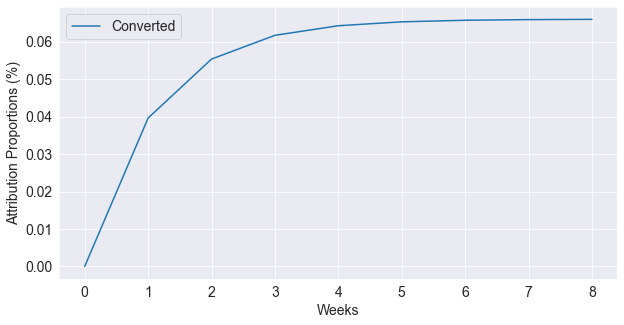

In [138]:
sns.set_style("darkgrid")

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 14

markovstates[["Converted"]].plot()

plt.xlabel("Weeks")
plt.ylabel("Attribution Proportions (%)")

plt.show()